# Multiclass Image Classification Project

# Analisis Sederhana  terhadap Data
Link dataset: https://www.kaggle.com/datasets/varpit94/disaster-images-dataset/code

Dataset yang digunakan terdiri atas 6 kategori utama, yaitu:
1. Damaged_Infrastructure (Earthquake, Infrastucture): gambar kerusakan infrastruktur / dampak gempa. 
2. Fire_Disaster (Urban_Fire, Wild_Fire): gambar kebakaran di urban fire dan wild fire.
3. Human_Damage: gambar dampak bencana terhadap manusia
4. Land_Disaster (Drought, Land_Slide): gambar bencana tanah seperti drought dan land slide.
5. Non_Damage (Non_Damage_Buildings_Street, Non_Damage_Wildfire_Forest, human, sea): gambar tanpa kerusakan, seperti bangunan dan hutan utuh, manusia, dan perairan.
6. Water_Disaster: gambar bencana yang disebabkan oleh air.

Untuk project multiclass image classification ini, terdapat 4 class yang akan digunakan, yaitu Earthquake, Urban_Fire, Land_Slide, dan Water_Disaster. Dari analisis pada tahap data preparation, dapat diketahui bahwa terdapat class imbalance pada Earthquake (jumlah gambarnya jauh lebih sedikit dibandingkan class lainnya), sehingga diperlukan beberapa pendekatan agar proses training tetap optiimal.

# Environment Setup

Import modules and libraries

In [1]:
import zipfile
import random
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image ,image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

Set up seed = 42

In [3]:
SEED_VALUE = 42
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Data Preparation

In [4]:
with zipfile.ZipFile('CDD.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

dataset_root = os.path.join('data', 'Comprehensive Disaster Dataset(CDD)')
dataset_path = 'data'
source_map = {
    'Fire_Disaster/Urban_Fire': 'Urban Fire',
    'Water_Disaster': 'Water Disaster',
    'Land_Disaster/Land_Slide': 'Land Slide',
    'Damaged_Infrastructure/Earthquake': 'Earthquake'
}

## EDA

**1. Distribusi jumlah gambar per class**

In [5]:
image_count = defaultdict(int)
for rel_path, class_name in source_map.items():
    full_path = os.path.join(dataset_root, rel_path)
    if os.path.isdir(full_path):
        count = len([
            fname for fname in os.listdir(full_path)
        ])
        image_count[class_name] += count

print("Jumlah gambar per class sebelum splitting:")
for cls, count in image_count.items():
    print(f"{cls}: {count}")

Jumlah gambar per class sebelum splitting:
Urban Fire: 419
Water Disaster: 1035
Land Slide: 456
Earthquake: 36


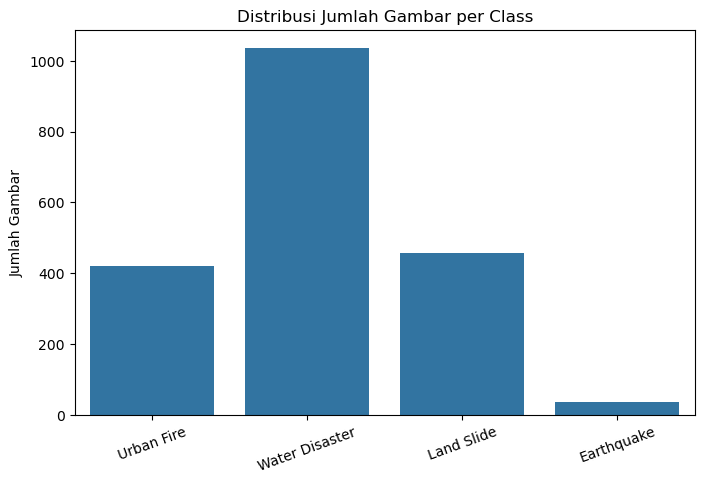

In [6]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(image_count.keys()), y=list(image_count.values()))
plt.title("Distribusi Jumlah Gambar per Class")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=20)
plt.show()

Dataset memiliki distribusi jumlah gambar yang tidak seimbang antar class. Terlihat bahwa Water Disaster (1035 gambar) mendominasi dataset, sementara Earthquake (36 gambar) sangat sedikit sehingga berpotensi menyebabkan **class imbalance** pada model.

**2. Contoh gambar dari setiap class**

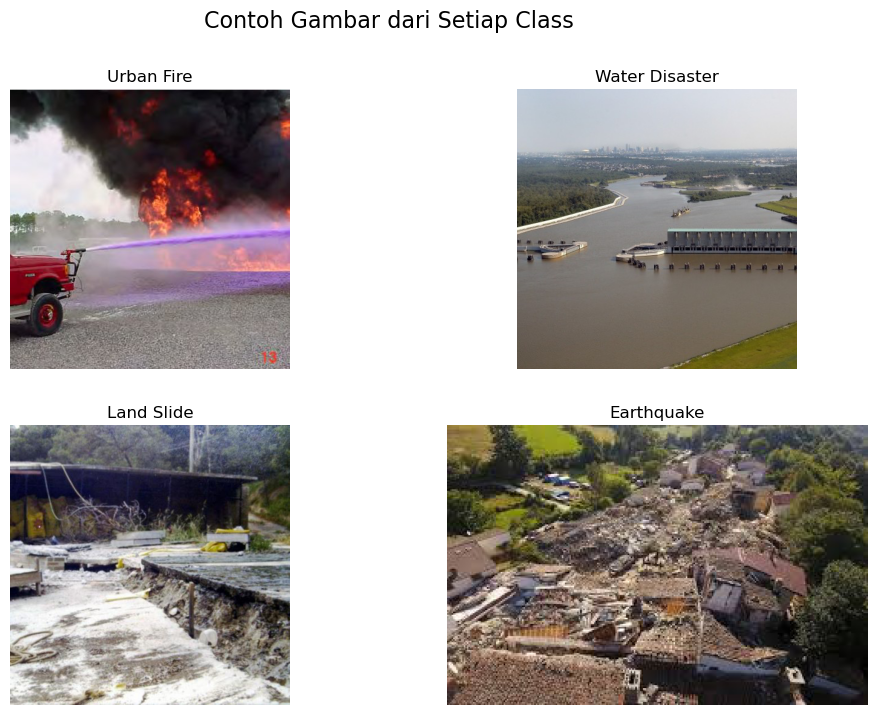

In [7]:
plt.figure(figsize=(12, 8))
for i, (rel_path, class_name) in enumerate(source_map.items()):
    full_path = os.path.join(dataset_root, rel_path)
    sample_img = random.choice(os.listdir(full_path))
    img = Image.open(os.path.join(full_path, sample_img))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.suptitle("Contoh Gambar dari Setiap Class", fontsize=16)
plt.show()

Berdasarkan contoh gambar dari masing-masing class di atas, dapat diketahui bahwa ciri khasnya adalah:
- Urban Fire: api di area perkotaan
- Water Disaster:  banjir atau bencana air
- Land Slide: longsor di area pemukiman atau jalan
- Earthquake: reruntuhan akibat gempa bumi

Visualisasi ini membantu memastikan bahwa label data sudah sesuai dengan isi gambar.

**3. Distribusi intensitas pixel (10 sample per class)**

In [8]:
sample_paths = []
for rel_path, _ in source_map.items():
    full_path = os.path.join(dataset_root, rel_path)
    sample_paths.extend([os.path.join(full_path, f) for f in os.listdir(full_path)[:10]]) 

pixels = []
for sp in sample_paths:
    img = Image.open(sp).convert("L")
    pixels.extend(np.array(img).flatten())
    img.close()

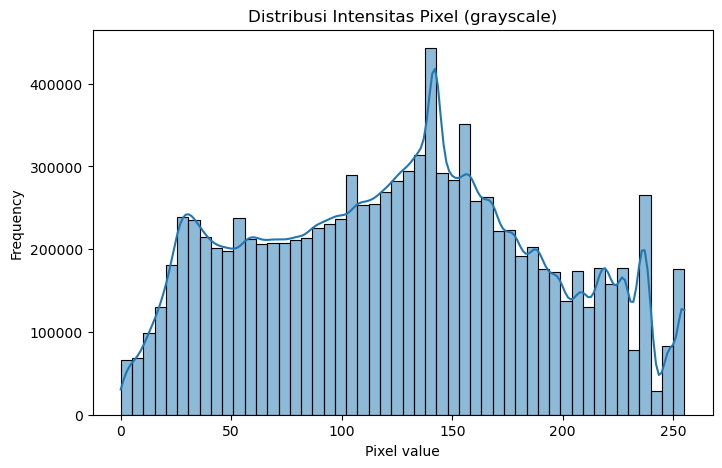

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(pixels, bins=50, kde=True)
plt.title("Distribusi Intensitas Pixel (grayscale)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

Analisis ini dilakukan dengan mengambil 10 sampel gambar dari tiap class (total 40 gambar), lalu mengonversinya ke grayscale dan menghitung distribusi nilai piksel (0 = hitam, 255 = putih).

- Nilai piksel tersebar dari 0 hingga 255, menandakan adanya variasi pencahayaan yang luas.  
- Terlihat puncak distribusi di sekitar 150, menandakan banyak gambar memiliki area terang.  
- Frekuensi piksel gelap (< 50) juga cukup tinggi, menandakan keberadaan objek kontras seperti api, reruntuhan, atau bayangan.  

Dapat disimpulkan bahwa dataset memiliki kontras tinggi antara area gelap dan terang, sehingga preprocessing seperti normalisasi pixel akan sangat dibutuhkan agar model lebih stabil saat training.

## Splitting Data

In [10]:
for split in ['train', 'test']:
    split_dir = os.path.join(dataset_path, split)
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir)

In [11]:
split_ratio = 0.8

for rel_path, label in source_map.items():
    src_folder = os.path.join(dataset_root, rel_path)
    all_files = [f for f in os.listdir(src_folder)]
    random.shuffle(all_files)

    split_idx = int(len(all_files) * split_ratio)
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    for fname in train_files:
        dst = os.path.join(dataset_path, 'train', label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(os.path.join(src_folder, fname), os.path.join(dst, fname))

    for fname in test_files:
        dst = os.path.join(dataset_path, 'test', label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(os.path.join(src_folder, fname), os.path.join(dst, fname))

    print(f"{label} - train: {len(train_files)}, test: {len(test_files)}")

Urban Fire - train: 335, test: 84
Water Disaster - train: 828, test: 207
Land Slide - train: 364, test: 92
Earthquake - train: 28, test: 8


In [12]:
def detect_tf_decode_errors(directory):
    problematic_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                try:
                    image_data = tf.io.read_file(file_path)
                    _ = tf.image.decode_image(image_data, channels=3)
                except tf.errors.InvalidArgumentError:
                    print("TensorFlow decode error:", file_path)
                    problematic_files.append(file_path)
    return problematic_files

train_dir = "data/train"
test_dir = "data/test"

errors_train = detect_tf_decode_errors(train_dir)
errors_test = detect_tf_decode_errors(test_dir)

TensorFlow decode error: data/train\Land Slide\04_01_0007.png
TensorFlow decode error: data/train\Land Slide\04_01_0335.png
TensorFlow decode error: data/train\Urban Fire\01_01_0060.png
TensorFlow decode error: data/test\Land Slide\04_01_0373.png


In [13]:
files_to_remove = [
    "data/train/Land Slide/04_01_0007.png",
    "data/train/Land Slide/04_01_0335.png",
    "data/train/Urban Fire/01_01_0060.png",
    "data/test/Land Slide/04_01_0373.png"
]

for file_path in files_to_remove:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"file removed: {file_path}")
    else:
        print(f"file not found: {file_path}")

file removed: data/train/Land Slide/04_01_0007.png
file removed: data/train/Land Slide/04_01_0335.png
file removed: data/train/Urban Fire/01_01_0060.png
file removed: data/test/Land Slide/04_01_0373.png


In [14]:
image_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    validation_split=0.2,
    subset="training",
    seed=SEED_VALUE,
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    validation_split=0.2,
    subset="validation",
    seed=SEED_VALUE,
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1552 files belonging to 4 classes.
Using 1242 files for training.
Found 1552 files belonging to 4 classes.
Using 310 files for validation.
Found 390 files belonging to 4 classes.


In [15]:
label_names = train_ds.class_names

## Normalization

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

Data normalization ini berfungsi untuk meningkatkan akurasi dengan mengubah pixel dari 0-255 (RGB) jadi nilai 0-1.

## Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

Data augmentation berfungsi untuk menghindari overfitting dengan menambah variasi data training secara acak.

## Prefetch

In [18]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Prefetch untuk meningkatkan optimasi performance.

# Modelling and Experimentation

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
all_labels = []
for images, labels in train_ds.unbatch():
    label_val = labels.numpy()
    if label_val.ndim > 0 and label_val.size > 1:
        label_scalar = np.argmax(label_val)  
    else:
        label_scalar = label_val.item()  
    all_labels.append(label_scalar)
    
all_labels = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("class weights:", class_weight_dict)

class weights: {0: 14.785714285714286, 1: 1.0315614617940199, 2: 1.154275092936803, 3: 0.4769585253456221}


Dari distribusi data di atas, terlihat bahwa jumlah sampel pada kelas Earthquake jauh lebih sedikit dibandingkan kelas lain (hanya 36 gambar). Jika dilakukan training pada dataset yang imbalanced, model cenderung bias terhadap kelas mayoritas dan menyyebabkan performa prediksi pada kelas minoritas (seperti Earthquake) akan buruk.

Untuk mengurangi masalah tersebut, digunakan metode class weighting, yaitu memberikan bobot lebih besar pada kelas yang jumlah datanya sedikit, dan bobot lebih kecil pada kelas dengan jumlah data yang banyak.

In [21]:
label_names

['Earthquake', 'Land Slide', 'Urban Fire', 'Water Disaster']

LABEL:

0 - Earthquake ; 1 - Land slide ; 2 - Urban Fire ; 3 - Water Disaster

## Model 1 (from scratch)

In [22]:
def design_model1(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


* Terdiri atas 4 hidden layers dengan aktivasi relu.
* Output layer menggunakan fungsi aktivasi softmax karena digunakan untuk klasifikasi multi-class.

In [23]:
model1 = design_model1()
model1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
history_model1 = model1.fit(train_ds,
                            validation_data=val_ds,
                            epochs=50,
                            callbacks=[early_stop],
                            class_weight=class_weight_dict)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3901 - loss: 13.6744 - val_accuracy: 0.2065 - val_loss: 5.9115
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4790 - loss: 12.7139 - val_accuracy: 0.0484 - val_loss: 10.7566
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4607 - loss: 8.5047 - val_accuracy: 0.2032 - val_loss: 16.0583
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5029 - loss: 7.4182 - val_accuracy: 0.4613 - val_loss: 4.6407
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5269 - loss: 3.8800 - val_accuracy: 0.5806 - val_loss: 2.5381
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4924 - loss: 3.0708 - val_accuracy: 0.4290 - val_loss: 2.7457
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4681 - loss: 3.8117 - val_accuracy: 0.5355 - val_loss: 6.3857
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4989 - loss: 4.4235 - val_accuracy: 0.3935 - val_l

## Model 2 (params < 10M)

In [26]:
def design_model2(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True

    for layer in base_model.layers[:-50]: 
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

* Output layer menggunakan fungsi aktivasi softmax karena digunakan untuk klasifikasi multi-class.

In [27]:
model2 = design_model2()
model2.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [28]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,019,588 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

Model 2 memiliki parameter kurang dari 10M, yaitu sebanyak 2,422,468 parameters, dengan trainable parameters sebanyak 2,019,588 parameters.

In [29]:
history_model2 = model2.fit(train_ds,
                            validation_data=val_ds,
                            epochs=50,
                            callbacks=[early_stop],
                            class_weight=class_weight_dict)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4319 - loss: 1.3842 - val_accuracy: 0.7355 - val_loss: 0.6650
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6588 - loss: 0.7380 - val_accuracy: 0.7645 - val_loss: 0.5461
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7628 - loss: 0.5676 - val_accuracy: 0.7806 - val_loss: 0.5580
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7866 - loss: 0.5068 - val_accuracy: 0.8097 - val_loss: 0.5090
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8196 - loss: 0.4267 - val_accuracy: 0.8097 - val_loss: 0.5443
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8166 - loss: 0.3878 - val_accuracy: 0.7871 - val_loss: 0.6200
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8677 - loss: 0.3076 - val_accuracy: 0.7968 - val_loss: 0.6183
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8911 - loss: 0.3105 - val_accuracy: 0.7871 - val_loss



Berdasarkan hasil evaluation, dapat diketahui bahwa model 2 adalah model yang lebih optimal dibandingkan model 1. 

Oleh karena itu, dilakukan hyperparameter tuning untuk mengetahui best learning rate pada model ini.

In [30]:
def design_tuning_model2(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True

    for layer in base_model.layers[:-50]: 
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [31]:
highest_accuracy= 0
best_learningrate = None
for lr in [0.001, 0.0001, 0.00001]:
    print(f"Learning rate = {lr}")

    tuning_model2 = design_tuning_model2()
    tuning_model2.compile(
        optimizer=keras.optimizers.Adam(learning_rate = lr),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    history_tuning_model2 = tuning_model2.fit(train_ds, 
                                              validation_data = val_ds, 
                                              epochs = 50,
                                              callbacks=[early_stop],
                                              class_weight=class_weight_dict)
    
    val_accuracy = max(history_tuning_model2.history['val_accuracy'])
    if val_accuracy > highest_accuracy:
        highest_accuracy = val_accuracy
        best_learningrate = lr
        best_model = tuning_model2

print(f"Learning rate with the highest accuracy is: {best_learningrate}")

Learning rate = 0.001
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6042 - loss: 1.0110 - val_accuracy: 0.7258 - val_loss: 1.1253
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7799 - loss: 0.5544 - val_accuracy: 0.6677 - val_loss: 1.3379
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8469 - loss: 0.4668 - val_accuracy: 0.5097 - val_loss: 2.5695
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7880 - loss: 0.6623 - val_accuracy: 0.4065 - val_loss: 3.8080
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8187 - loss: 0.4592 - val_accuracy: 0.5516 - val_loss: 3.1095
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8496 - loss: 0.3810 - val_accuracy: 0.4484 - val_loss: 5.1572
Learning rate = 0.0001
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4328 - loss: 1.3370 - val_accuracy: 0.7323 - val_loss: 0.7277
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6899 - lo

# Evaluation

## Berdasarkan hasil plot accuracy dan loss

In [33]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

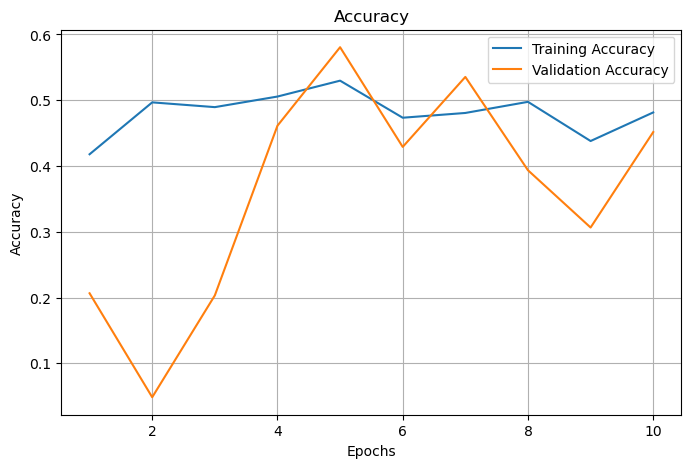

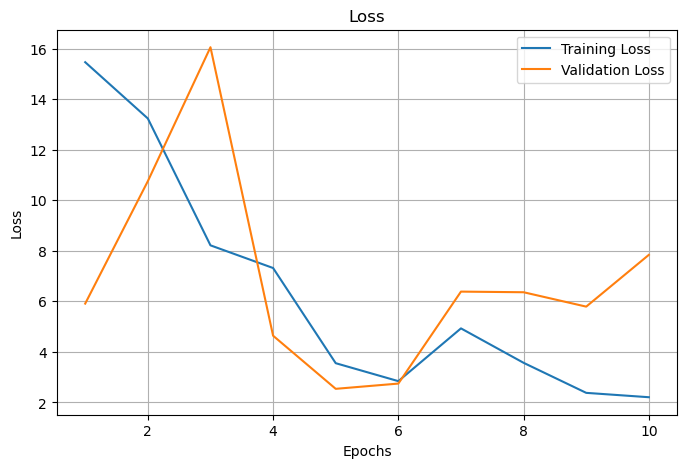

In [34]:
plot_history(history_model1, model1)

Berdasarkan grafik hasil training model 1, dapat dilihat bahwa:
* Training accuracy meningkat secara bertahap dari awal hingga mencapai sekitar 53% pada epoch ke-5, kemudian fluktuatif di kisaran 45–50% hingga akhir.
* Validation accuracy sempat mengalami peningkatan signifikan pada epoch ke-3 hingga ke-5, namun setelah itu cenderung menurun cukup drastis hingga sekitar 30% di epoch ke-9, lalu sedikit meningkat kembali pada epoch ke-10 (sekitar 45%).
* Training loss menurun konsisten dari awal hingga menjadi sekeitar 2.2 pada akhir epoch.
* Validation loss sangat fluktuatif: naik tajam di awal hingga ~16 (epoch ke-3), kemudian turun drastis hingga sekitar 2.5 pada epoch ke-5–6, tetapi kembali meningkat hingga 8 pada akhir epoch.
  
Secara keseluruhan, grafik ini menunjukkan bahwa model masih dalam proses belajar yang cukup baik, namun performanya masih tergolong moderate karena belum menunjukkan generalisasi yang sangat kuat.

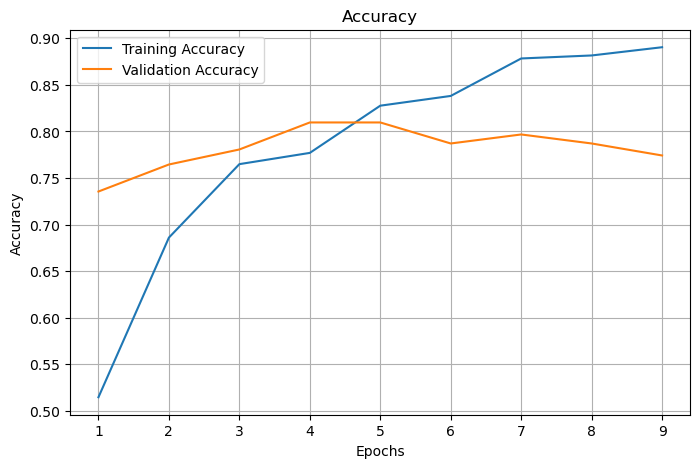

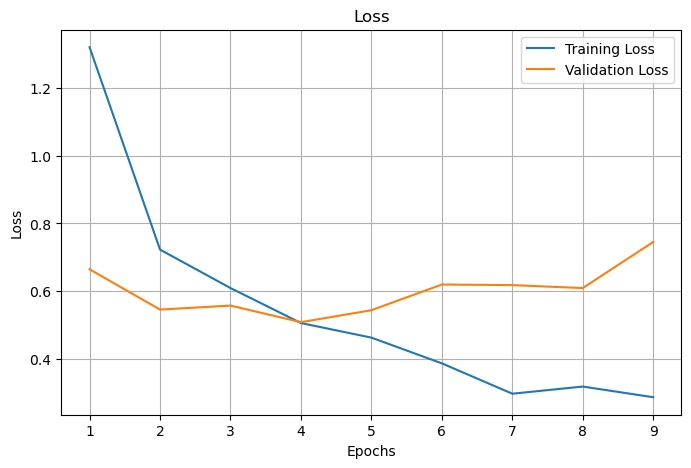

In [35]:
plot_history(history_model2, model2)

Berdasarkan grafik hasil training model 2 (parameter < 10M), dapat dilihat bahwa:
* Training accuracy meningkat secara stabil dan konsisten, dari sekitar 51% pada epoch pertama hingga 89% pada epoch ke-9.
* Validation accuracy mengalami peningkatan hingga epoch ke-5, kemudian cenderung stagnan bahkan sedikit menurun setelah epoch ke-6. Hal ini mengindikasikan bahwa meskipun model semakin baik pada data training, kemampuannya untuk menggeneralisasi ke data validasi mulai menurun.
* Training loss mengalami penurunan yang signifikan dan stabil, yang menandakan bahwa model terus memperbaiki prediksinya terhadap data yang sudah dikenal.
* Validation loss mengalami penurunan yang cenderung stagnan, bahkan sedikit meningkat setelah epoch ke-6, kemungkinan besar overfitting.

Melalui kedua grafik tersebut, dapat diketahui bahwa model ke-2 yang memanfaatkan arsitektur MobileNetV2 ini menunjukkan hasil yang lebih efisien dibandingkan model 1. Hal tesebut dikarenakan hasil accuracy training dan validation yang lebih tinggi dan stabil.

## Berdasarkan hasil classification report dan correlation matrix

In [36]:
def evaluate(model, test_ds, label_names):
    y_true = []
    y_pred = []
    for x, y in test_ds:
        pred = model.predict(x)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(np.argmax(y.numpy(), axis=1))
    
    print(classification_report(y_true, y_pred, target_names=label_names))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=label_names).plot()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
                precision    recall  f1-score   support

    Earthquake       0.09      0.12      0.11         8
    Land Slide       0.34      0.37      0.35        91
    Urban Fire       0.86      0.07      0.13        84
Water Disaster       0.63      0.83      0.72       207

      accuracy                           0.55       390
     macro avg       0.48      0.35      0.33       390
  weighted avg       0.60      0.55      0.50       390



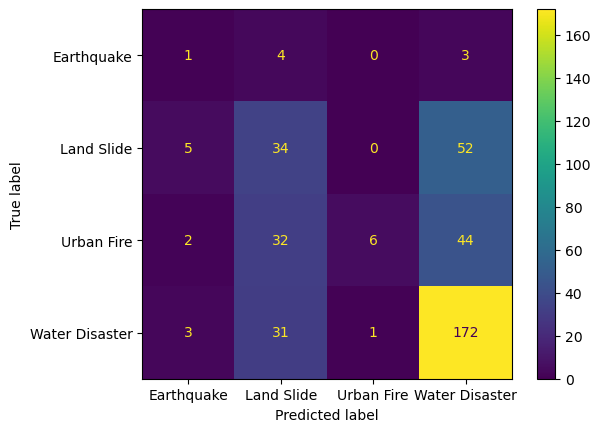

In [37]:
evaluate(model1, test_ds, label_names)

Berdasarkan hasil correlation matrix model 1, dapat diketahui bahwa model 1 paling baik mengenali Water Disaster dengan prediksi benar terbanyak, sementara kelas Earthquake dan Urban Fire sulit dikenali karena banyak salah klasifikasi. Selain itu, terdapat kekeliruan yang cukup besar antara kelas Land Slide dan Water Disaster.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                precision    recall  f1-score   support

    Earthquake       0.21      0.75      0.32         8
    Land Slide       0.78      0.47      0.59        91
    Urban Fire       0.97      0.75      0.85        84
Water Disaster       0.80      0.93      0.86       207

      accuracy                           0.78       390
     macro avg       0.69      0.73      0.66       390
  weighted avg       0.82      0.78      0.78       390



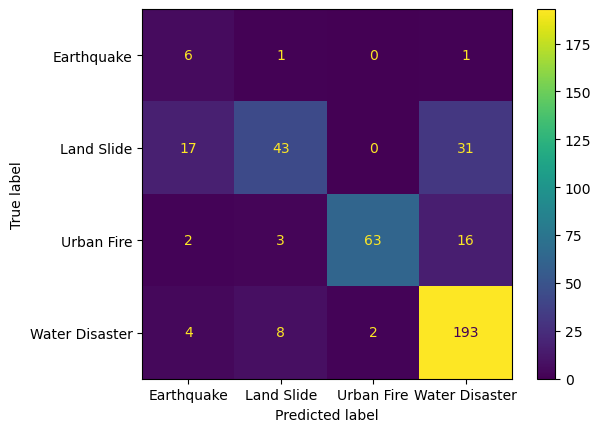

In [38]:
evaluate(model2, test_ds, label_names)

Jika dilihat berdasarkan classification report dan correlation matrix kedua model tersebut, dapat disimpulkan bahwa secara keseluruhan, model ke-2 adalah model yang lebih optimal dibandingkan model ke-1 untuk dataset ini. Model 2 lebih unggul dalam semua metric dan kemampuannya dalam mengklasifikasikan class minoritas seperti Earthquake dengan f1-score yang meningkat signifikan dibanding model pertama. 

## Best Model

BEST MODEL = MODEL 2

Evaluasi untuk best model yang telah di hyperparameter tuning

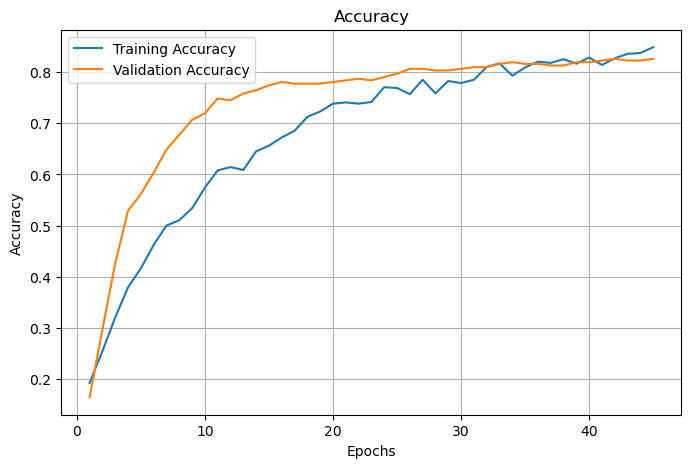

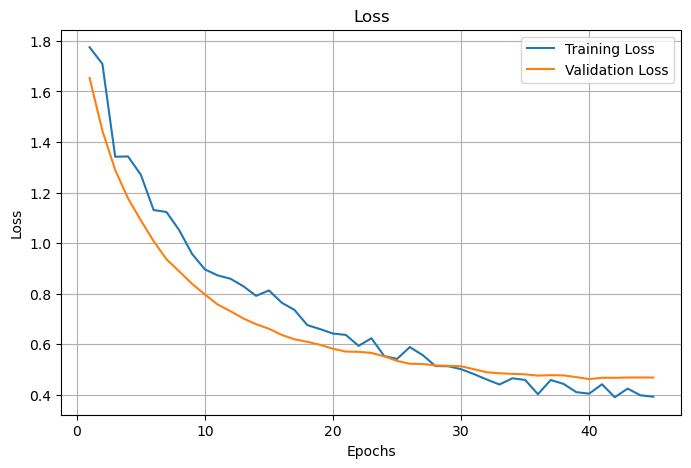

In [39]:
plot_history(history_tuning_model2, best_model)

Berdasarkan grafik hasil training dari best model (model 2 dengan learning rate 0.00001), dapat dilihat bahwa:
* Training accuracy meningkat secara konsisten dari 20% hingga mencapai angka yang cukup tinggi sekitar 85% di akhir epoch.
* Validation accuracy naik cukup tajam pada awal training, kemudian cenderung stabil di kisaran 80%, yang berarti model mmapu menjaga performanya pada data validasi.
* Training loss menurun signifikan dari awal dan terus berkurang hingga berada di bawah 0.4, menunjukkan bahwa model terus memperbaiki prediksinya terhadap data training.
* Validation loss juga menunjukkan pola penurunan yang konsisten dan stabil hingga akhir epoch.

Grafik ini memperlihatkan bahwa model belajar secara efektif dan mampu melakukan generalisasi dengan baik terhadap data validasi. Performa stabil tanpa gejala overfitting serius, sehingga model ini lebih efisien dan lebih baik dibanding model 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
                precision    recall  f1-score   support

    Earthquake       0.18      0.88      0.30         8
    Land Slide       0.74      0.56      0.64        91
    Urban Fire       0.93      0.92      0.92        84
Water Disaster       0.92      0.88      0.90       207

      accuracy                           0.82       390
     macro avg       0.69      0.81      0.69       390
  weighted avg       0.86      0.82      0.83       390



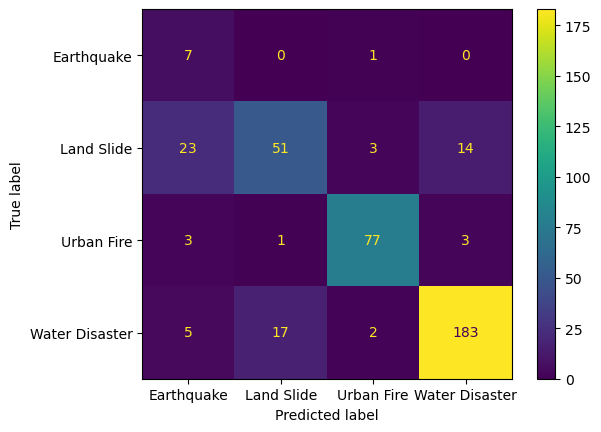

In [40]:
evaluate(best_model, test_ds, label_names)

Best model (hasil hypertuning model 2) menunjukkan performa model yang sudah sangat baik dengan akurasi keseluruhan sebesar 82%. Model mampu mengenali kelas Urban Fire dan Water Disaster dengan sangat baik (f1-score di atas 0.9), sementara kelas Land Slide juga cukup solid dengan F1-score 0.64. Bahkan untuk kelas Earthquake, meski datanya lebih sedikit, recall mencapai 0.88 yang berarti model cukup handal dalam mendeteksi kejadian tersebut. Secara keseluruhan, hasil ini membuktikan bahwa hypertuning berhasil meningkatkan kualitas model.

# Documentation

In [41]:
def predictions_of_the_best_model(model, dataset, num_images, label_names):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_labels = tf.argmax(preds, axis=1).numpy()
        true_labels = tf.argmax(labels, axis=1).numpy()

        num_to_show = min(num_images, images.shape[0])

        plt.figure(figsize=(18, num_to_show // 5 * 3))
        for i in range(num_to_show):
            ax = plt.subplot((num_to_show + 4) // 5, 5, i + 1)  
            img = (images[i].numpy() * 255).astype("uint8")
            plt.imshow(img)
            plt.title("Hasil prediksi dari best model")
            true_text = label_names[true_labels[i]]
            pred_text = label_names[pred_labels[i]]
            color = "green" if true_text == pred_text else "red"
            plt.title(f"True:\n{true_text}\nPred:\n{pred_text}", fontsize=9, color=color)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


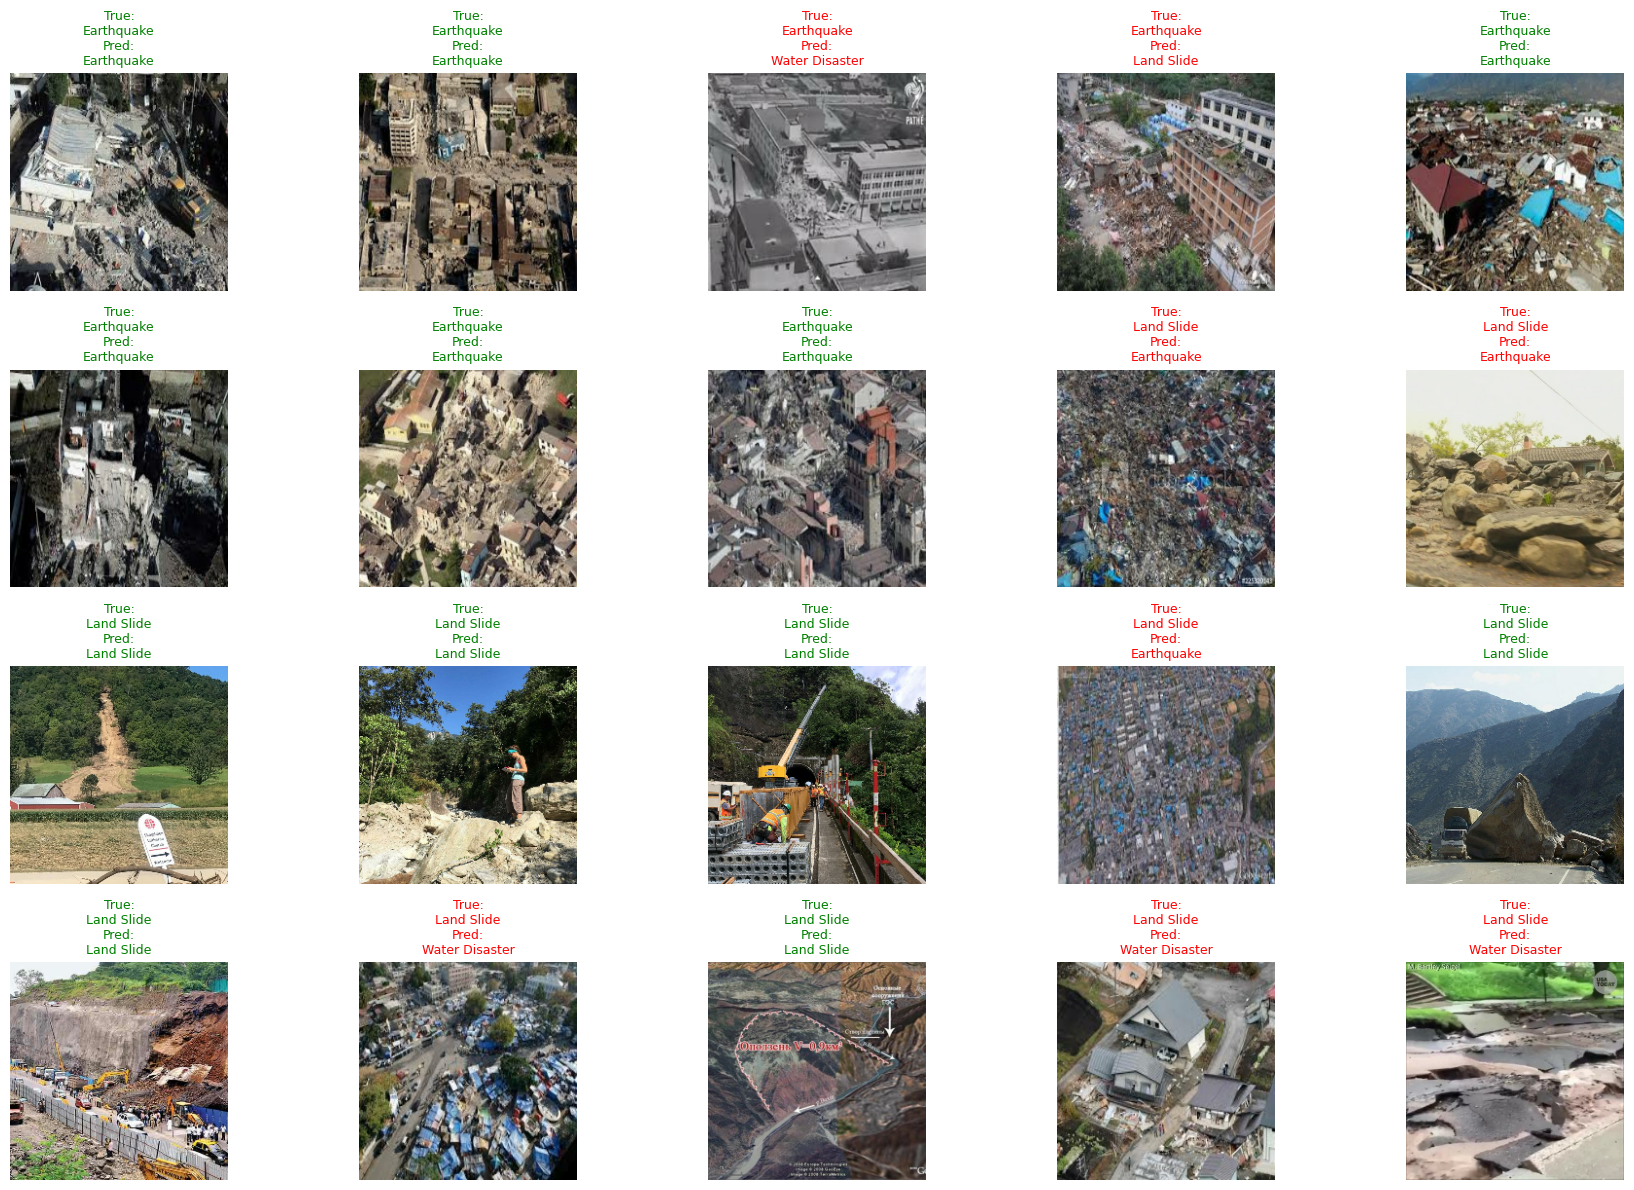

In [42]:
num_images = 20
predictions_of_the_best_model(model2, test_ds, num_images, label_names)

Distribusi data yang digunakan:
* Urban Fire: 419
* Water Disaster: 1035
* Land Slide: 456
* Earthquake: 36 -> unbalanced sehingga menggunakan class_weight dengan perbandingan:
  
Earthquake: 14.785714285714286, Urban Fire: 1.0315614617940199, Land Slide: 1.154275092936803, Water Disaster: 0.4769585253456221


Dimensi setiap gambar di resize menjadi 224 x 224

In [43]:
model1.evaluate(val_ds)
model1.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.5533 - loss: 2.6707
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4056 - loss: 3.2489


[2.556565046310425, 0.5461538434028625]

In [44]:
best_model.evaluate(val_ds)
best_model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - accuracy: 0.8106 - loss: 0.4907
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - accuracy: 0.7407 - loss: 0.7133


[0.5448195338249207, 0.8153846263885498]

Model 2 yang menggunakan arsitektur MobileNetV2 (dengan learning rate 0.0001) terbukti lebih unggul dibandingkan model 1. Hal tersebut dikarenakanmodel 2 memanfaatkan arsitektur MobileNetV2 yang memang dirancang untuk efisiensi komputasi, sehingga sangat cocok digunakan dalam proyek klasifikasi gambar seperti ini yang membutuhkan performa tinggi namun tetap ringan dari sisi resource. Dengan memanfaatkan transfer learning dari MobileNetV2, proses training menjadi lebih cepat dan hasilnya juga lebih akurat.

Selain itu, dari hasil training, model 2 menunjukkan akurasi validasi yang lebih tinggi dan lebih stabil dibandingkan model 1, yang menunjukkan bahwa model tidak hanya belajar dengan baik dari data training, tetapi juga mampu melakukan generalisasi dengan lebih baik terhadap data yang belum pernah dilihat sebelumnya. Sedangkan model 1 merupakan arsitektur CNN yang dibangun from scratch, dengan struktur yang relatif sederhana, sehingga model ini kurang mampu menangkap pola fitur yang kompleks dan cenderung menghasilkan model yang bias terhadap data training (contohnya biased pada Water_Disaster).

